## Import

In [1]:
import os, io, gc, glob
import numpy as np
import pandas as pd
import pickle
import random

from scipy.fft import fft
from scipy.signal import hilbert, blackman
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten ,Dropout, Activation
from tensorflow.keras.layers import Add, concatenate
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')
gc.enable()

In [2]:
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
plt.rcParams["figure.figsize"] = (10,15)

## Fix Seed

In [3]:
SEED = 42
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
seed_everything()

## Hyperparameter Setting

In [4]:
# Model Configuration
class CFG:
    seed = 42
    VERBOSE = 1
    random_state = 42
    N_FOLDS = 28
    EPOCHS = 400
    WINDOW_SIZE = 24
    BATCH_SIZE = 16
    factor = 0.5
    patience_1 = 5
    patience_2 = 15
    learning_rate = 1e-3
    weight_decay = 1e-3
    dropout_rate = 0.2
    features_num = 15

## Data Scope Setting

In [5]:
class SCOPE:
    AVG_TEMP_PER_HOUR = (4.0,40.0) # 시간당 내부 평균온도
    AVG_HUMI_PER_HOUR = (0.0,100.0) # 시간당 내부 평균습도
    AVG_CO2_PER_HOUR = (0.0,1200.0) # 시간당 내부 평균 co2 농도
    AVG_EC_PER_HOUR = (0.0,8.0) # 시간당 평균 EC
    WATER_PER_HOUR = (0.0,3000.0) # 시간당 분무량
    WATER_PER_DAY = (0.0,72000.0) # 일간 누적 분무량
    LIGHT_PER_HOUR = (0.0,120000.0) # 시간당 광량 (백색,적색,청색,총 모두다 동일)
    LIGHT_PER_DAY = (0.0, 2880000.0) # 일간 누적 광량 (백색,적색,청색,총 모두다 동일)

## Data loading

In [6]:
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))

df_train_input = pd.concat(map(pd.read_csv, all_input_list)).drop(columns='obs_time').reset_index(drop=True)
df_train_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT').reset_index(drop=True)

## Data analysis

In [7]:
# 연속된 리스트들의 리스트를 받았을 때 이를 나누어주는 함수
def divide_list(lists):
    result = []
    f = lambda arr, x: arr[:-1] + [arr[-1] + [x]] if arr and arr[-1][-1]+1 == x else arr + [[x]]
    for i in lists:
        result = f(result, i)
    return result

In [8]:
df_train_input.shape

(18816, 15)

In [9]:
df_train_input.dropna(axis=0, inplace=True)
df_train_input.shape

(18816, 15)

In [10]:
df_train_input.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.027719,63.935090,498.860695,1.507566,523.627918,6365.916673,6315.562930,72910.240149,1571.862912,18201.358998,1241.905981,14139.184959,9129.331824,105250.784106
std,8.077962,3.948988,11.657905,120.421248,1.042010,544.323281,6903.680044,8188.067575,86040.447105,2937.252667,34386.384982,2474.426437,27743.227265,9175.427411,97397.224913
min,0.000000,0.000000,0.000000,60.400000,0.000000,-653.260000,0.000000,-138371.246100,0.000000,-8793.607200,0.000000,-18570.857500,0.000000,-165735.710800,0.000000
25%,6.750000,23.971250,57.494583,420.245833,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291667,62.118333,473.983333,1.308517,252.000000,3360.485000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92172.360000
75%,20.250000,28.106667,73.157166,551.105952,2.291322,769.000000,9990.570000,18236.625400,145422.700000,1494.698100,17529.296400,1306.461000,18484.700000,18255.190000,177491.499450
max,27.000000,42.643334,93.350002,1714.850000,5.462324,3144.130000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


In [11]:
def showplot(df,columns,xtick_num=28,colors=[]):
    x = df.index
    if len(columns) == 1:
        plt.plot(x,df[columns])
    else:
        fig, ax = plt.subplots(len(columns),1)
        for idx,(a,column) in enumerate(zip(ax,columns)):
            if len(columns) == len(colors):
                a.plot(x,df[column], color=colors[idx])
            else:
                a.plot(x,df[column])
            a.set_xlim(x[0],x[-1])
            a.set_xticks(np.linspace(x[0],x[-1],num=xtick_num+1))
            a.set_xticklabels(range(0,xtick_num+1))
            a.grid(axis='x')
            a.set_title(column)
        fig.tight_layout()
    plt.show()

#### 입력값으로 주어지는 상추들은 총 28개의 케이스로 각 28일간의 데이터가 있다. 각 28일은 또 24시간으로 1시간 기준 데이터로 나누어져 있다. 그래프는 28개의 상추들을 모두 일렬로 이어 붙여 하나의 그래프로 표현하였다.
#### Ex. (0-1) 사이의 데이터 == 1번째 상추 28일간의 데이터 / (19-20) 사이의 데이터 == 20번째 상추의 28일간의 데이터

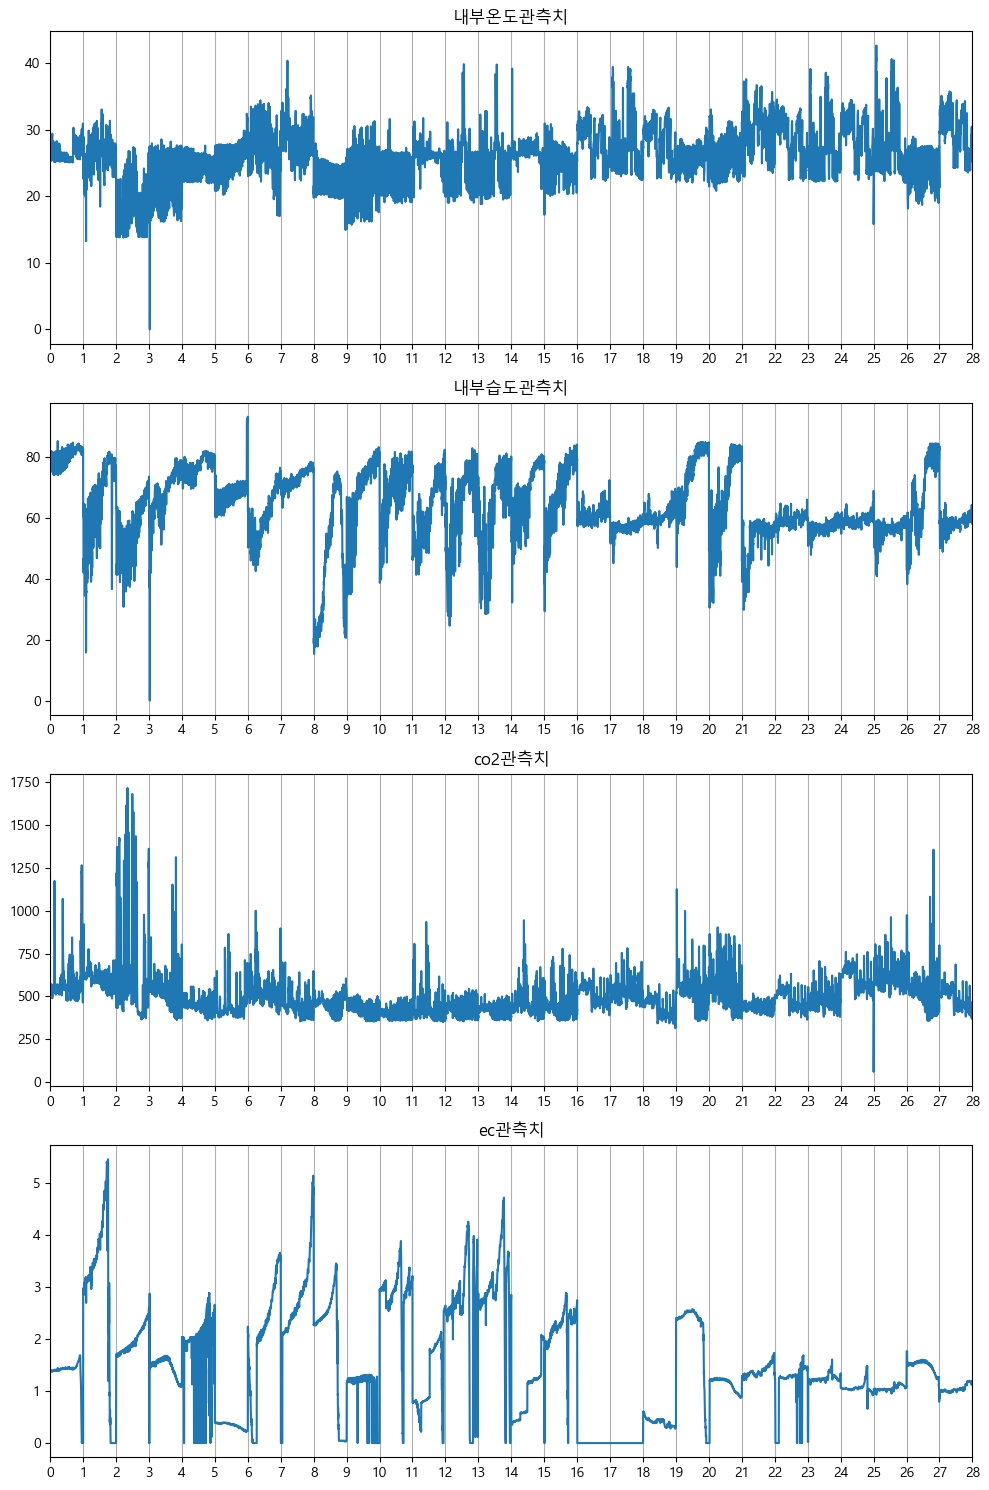

In [12]:
showplot(df_train_input,['내부온도관측치','내부습도관측치','co2관측치','ec관측치'],28)

#### 내부온도, 내부습도, co2 모두 급작스럽게 0으로 떨어지는 구간이 존재한다. ec의 경우는 판단하기 어렵다

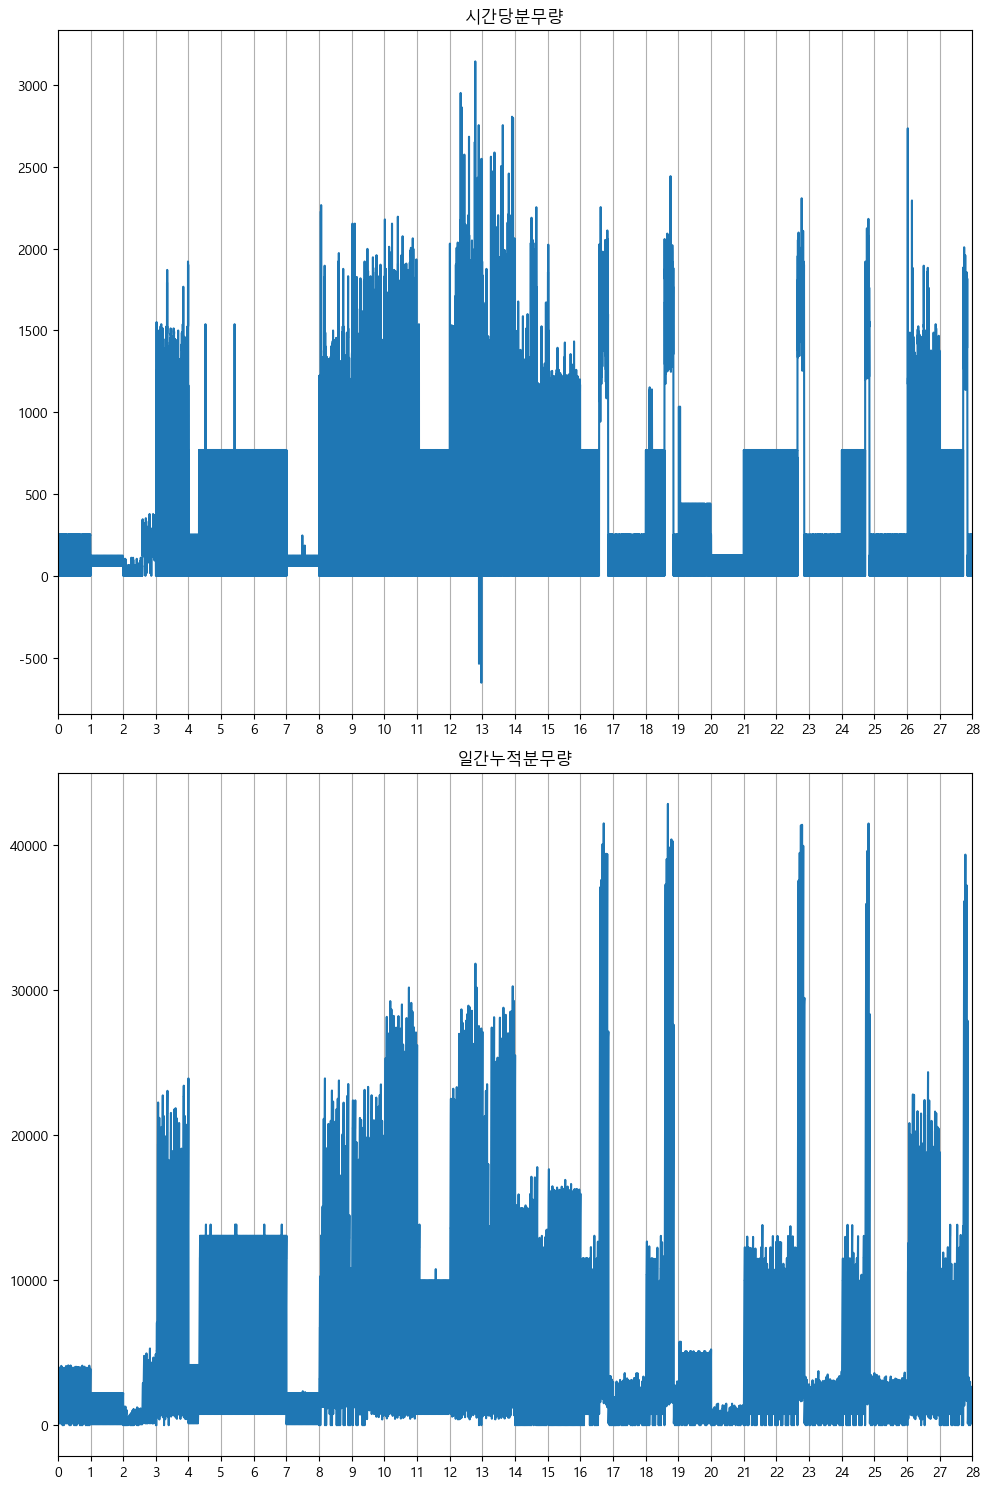

       시간당분무량   일간누적분무량
8662  1120.05  26271.86
8663  1261.51  27533.37
8664   537.52    537.52
8665  -537.52      0.00
8666  1415.83   1415.83
8667     0.00   1415.83
       시간당분무량   일간누적분무량
8710  2433.00  26162.55
8711  1203.64  27366.19
8712   653.26    653.26
8713  -653.26      0.00
8714  1415.83   1415.83
8715     0.00   1415.83


In [13]:
showplot(df_train_input,['시간당분무량','일간누적분무량'],28)

anomaly_water_idx_lists = divide_list(df_train_input[df_train_input['시간당분무량'] < 0].index)
for idx_list in anomaly_water_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당분무량':'일간누적분무량'])

#### 시간당 누적량은 0 미만이 될 수 없다. 7500~10000 사이에서 이상값을 발견할 수 있다. 누적분무량도 영향을 받은 것을 알 수 있다.

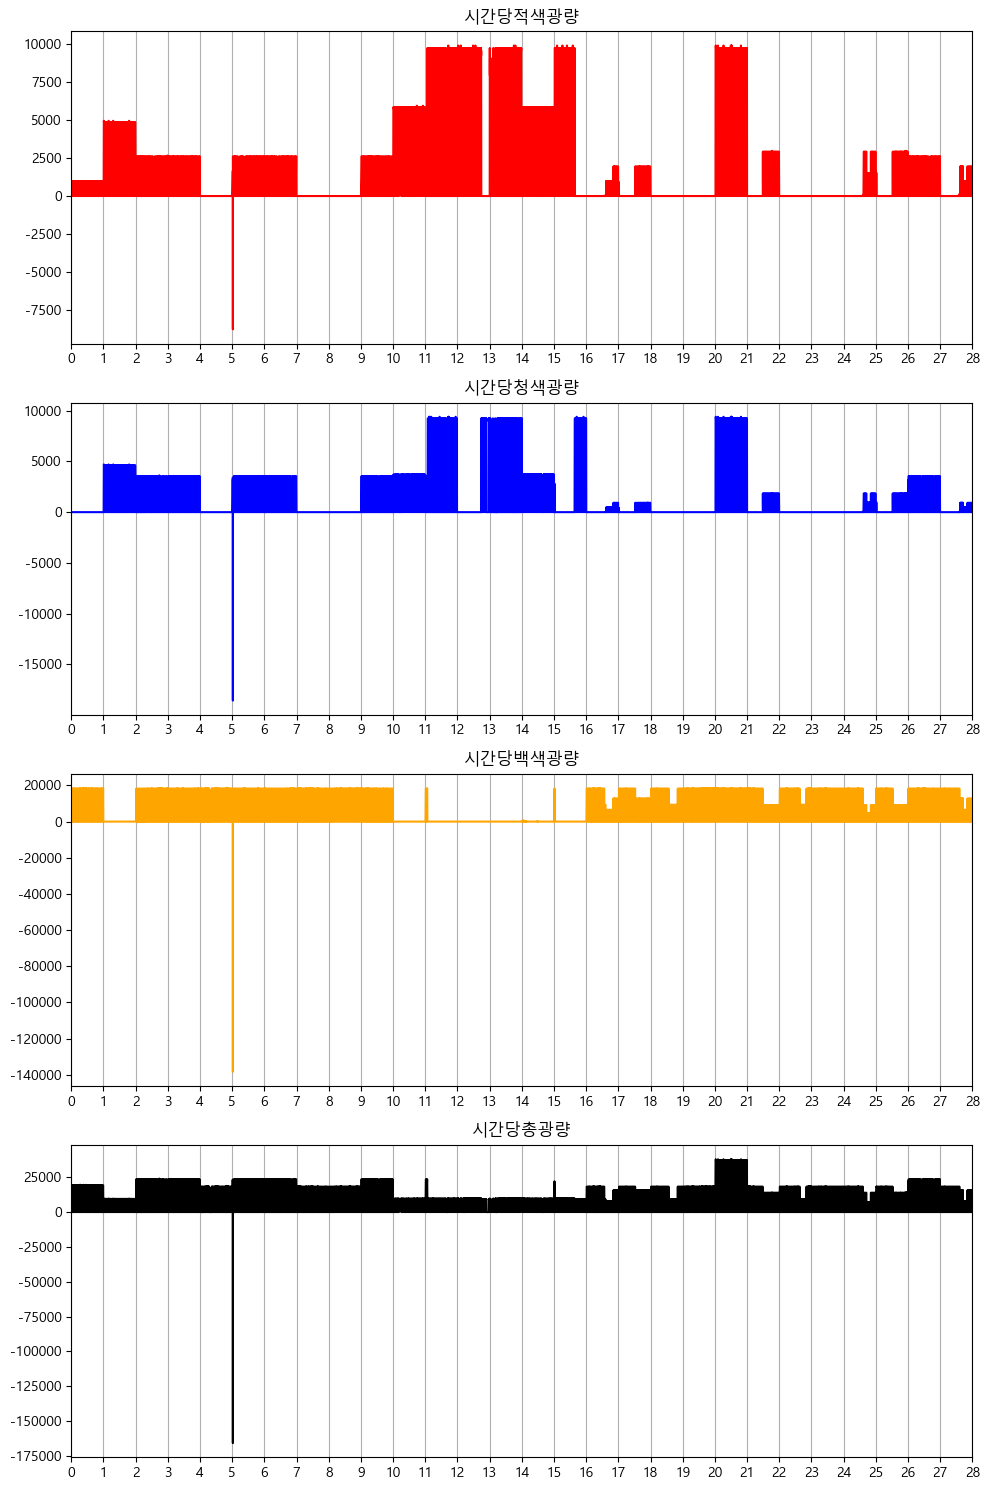

In [14]:
showplot(df_train_input, ['시간당적색광량','시간당청색광량','시간당백색광량','시간당총광량'],xtick_num=28,colors=['red','blue','orange','black'])

#### 시간당 광량들에게서도 이상값이 발견된다. 0 이하가 될 수 없다.

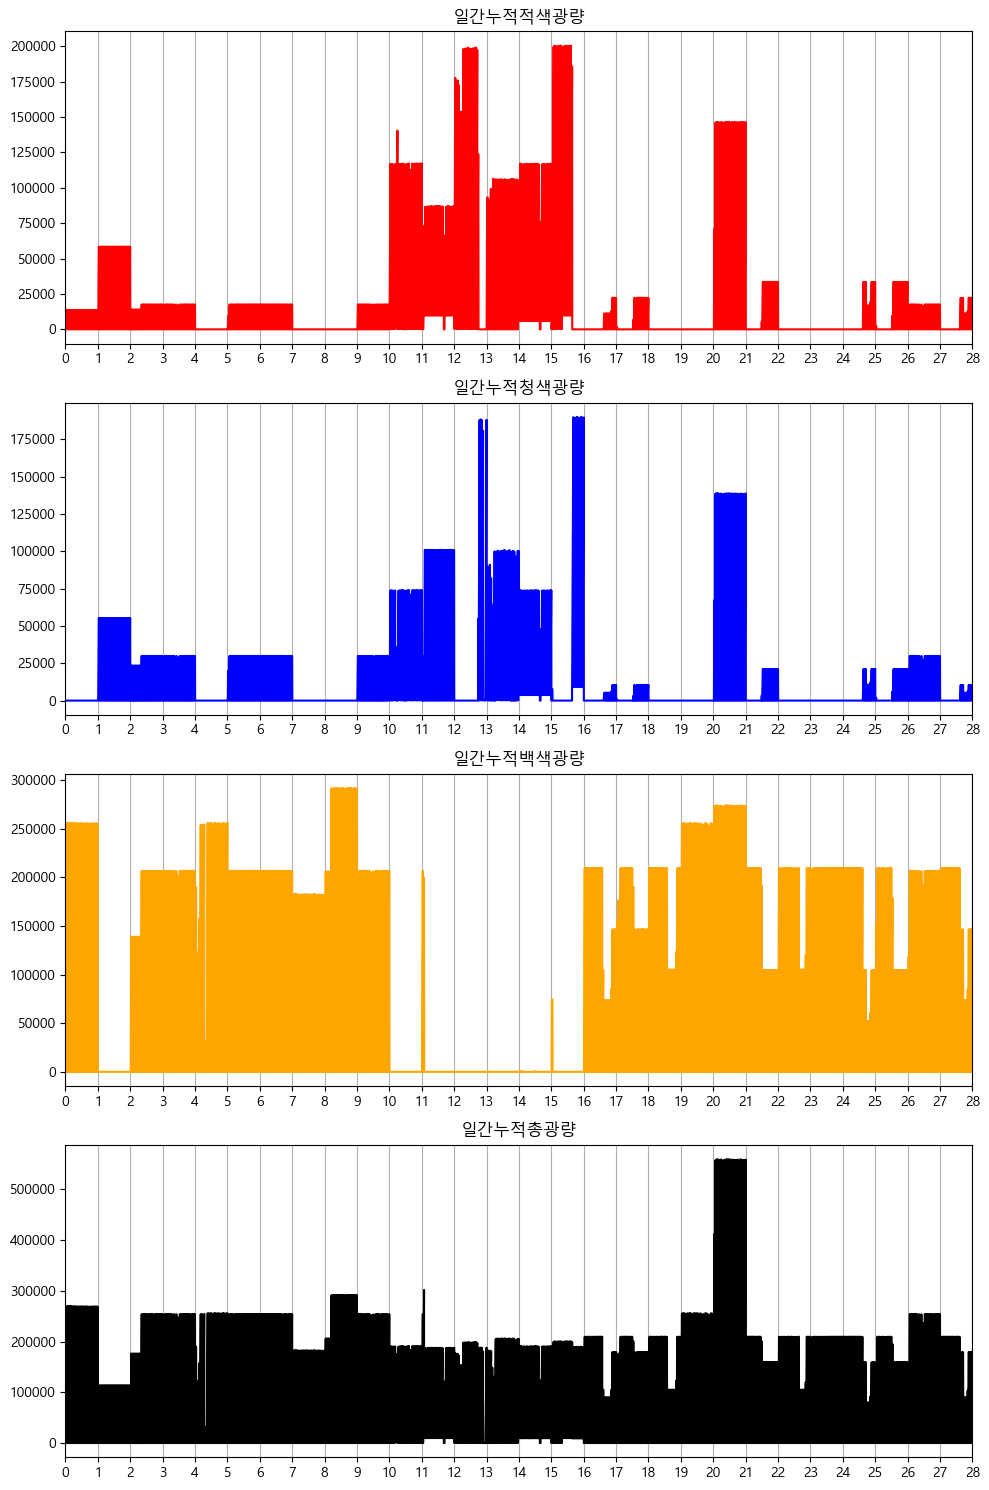

In [15]:
showplot(df_train_input, ['일간누적적색광량','일간누적청색광량','일간누적백색광량','일간누적총광량'],xtick_num=28,colors=['red','blue','orange','black'])

In [16]:
anomaly_redlight_idx_lists = divide_list(df_train_input[df_train_input['시간당적색광량'] < 0].index)
anomaly_bluelight_idx_lists = divide_list(df_train_input[df_train_input['시간당청색광량'] < 0].index)
anomaly_whitelight_idx_lists = divide_list(df_train_input[df_train_input['시간당백색광량'] < 0].index)
anomaly_light_idx_lists = divide_list(df_train_input[df_train_input['시간당총광량'] < 0].index)
for idx_list in anomaly_redlight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당적색광량':'일간누적적색광량'])
for idx_list in anomaly_bluelight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당청색광량':'일간누적청색광량'])
for idx_list in anomaly_whitelight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당백색광량':'일간누적백색광량'])
for idx_list in anomaly_light_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당총광량':'일간누적총광량'])

        시간당적색광량   일간누적적색광량
3372  1323.8400  6326.3004
3373  1495.9392  7822.2396
3374  1659.7644  9482.0040
3375 -8793.6072   688.3968
3376  2128.0728  2816.4696
3377  2616.2388  5432.7084
         시간당청색광량    일간누적청색광량
3372   3101.6700  13258.8560
3373   3264.5860  16523.4420
3374   3419.6695  19943.1115
3375 -18570.8575   1372.2540
3376   3223.8570   4596.1110
3377   2302.7550   6898.8660
          시간당백색광량     일간누적백색광량
3372   18255.1900  108977.2961
3373   18255.1900  127232.4861
3374   18255.1900  145487.6761
3375 -138371.2461    7116.4300
3376   17744.6635   24861.0935
3377   16831.9040   41692.9975
           시간당총광량      일간누적총광량
3372   22680.7000  128562.4525
3373   23015.7152  151578.1677
3374   23334.6239  174912.7916
3375 -165735.7108    9177.0808
3376   23096.5933   32273.6741
3377   21750.8978   54024.5719


#### 시간당 광량의 음수 문제로 누적총광량까지 영향을 미쳤다.

## Preprocessing method

In [17]:
def impute_data(df,col_idx,sta_value,beq=True,mode='mean'):
    if beq:
        index_lists = df[df.iloc[:,col_idx] >= sta_value].index
    else:
        index_lists = df[df.iloc[:,col_idx] < sta_value].index
        
    index_lists = divide_list(index_lists)
    for index_list in index_lists:
        # 이상값 기준으로 위 아래 값 포함하여 평균값으로 바꾸어준다.
        if mode == 'mean':
            df.iloc[range(index_list[0]-1,index_list[-1]+2),col_idx] = np.mean(df.iloc[index_list[0]-2,col_idx]+df.iloc[index_list[-1]+2,col_idx])
        # 이상값을 최대, 최소값으로 바꾼다.
        elif mode == 'const':
            df.iloc[index_list,col_idx] = sta_value
        # 이상값을 바로 전 값에서 가져온다.
        elif mode == 'impute':
            for idx in index_list:
                df.iloc[idx,col_idx] = df.iloc[idx-1,col_idx]
    return df

# 24시간기준 누적합 feature 생성함수
def cumsum_feature(df,col_idx):
    for idx_list in np.array(df.index).reshape(-1,CFG.WINDOW_SIZE):
        cum = 0
        for idx in idx_list:
            cum += df.iloc[idx,col_idx-1]
            df.iloc[idx,col_idx] = cum
    return df

def feature_processing(df):
    idx_observe = [1,2,3] # 관측값들 (ec관측값 제외)
    idx_per_hour = [5,7,9,11] # 시간당 분무량, 광량 등...
    
    impute_data(df,1,SCOPE.AVG_TEMP_PER_HOUR[0],False)
    impute_data(df,1,SCOPE.AVG_TEMP_PER_HOUR[1],mode='const')
    impute_data(df,2,4,False,mode='mean')
    impute_data(df,3,200,False,mode='mean')
    for idx in idx_per_hour:
        impute_data(df,idx,0,False,mode='impute')
        df = cumsum_feature(df,idx+1)
    for idx in df.index:
        df.iloc[idx,13] = df.iloc[idx,7]+df.iloc[idx,9]+df.iloc[idx,11]
    df = cumsum_feature(df,14)
    return df
        

## Preprocessing 진행 후

In [18]:
df_train_input = feature_processing(df_train_input)

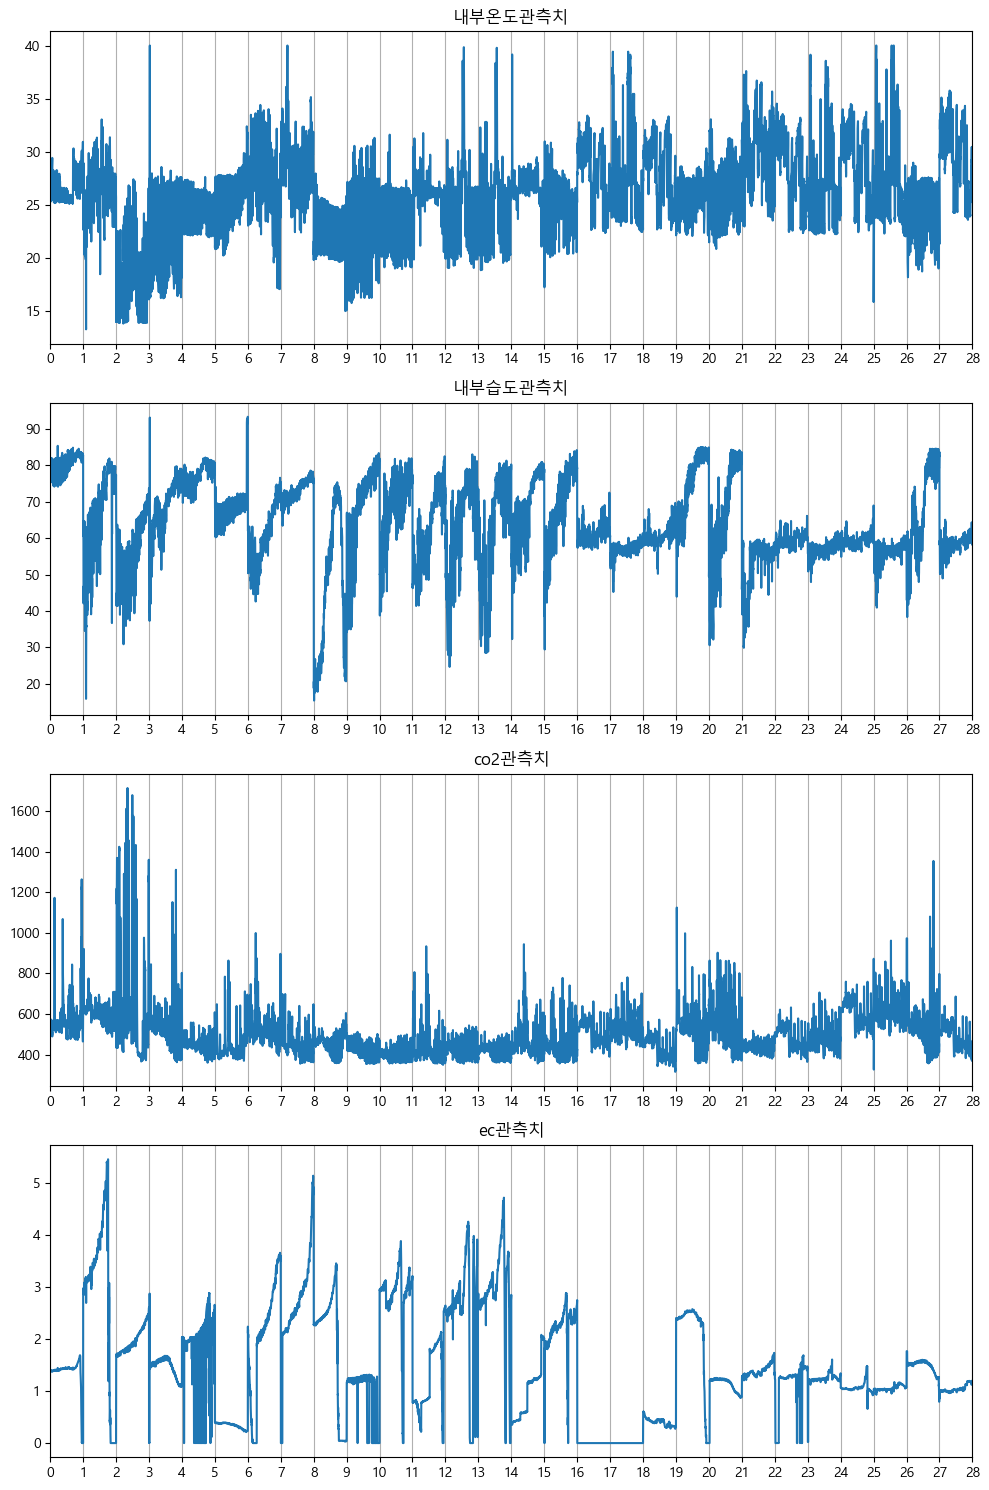

In [19]:
showplot(df_train_input,['내부온도관측치','내부습도관측치','co2관측치','ec관측치'],28)

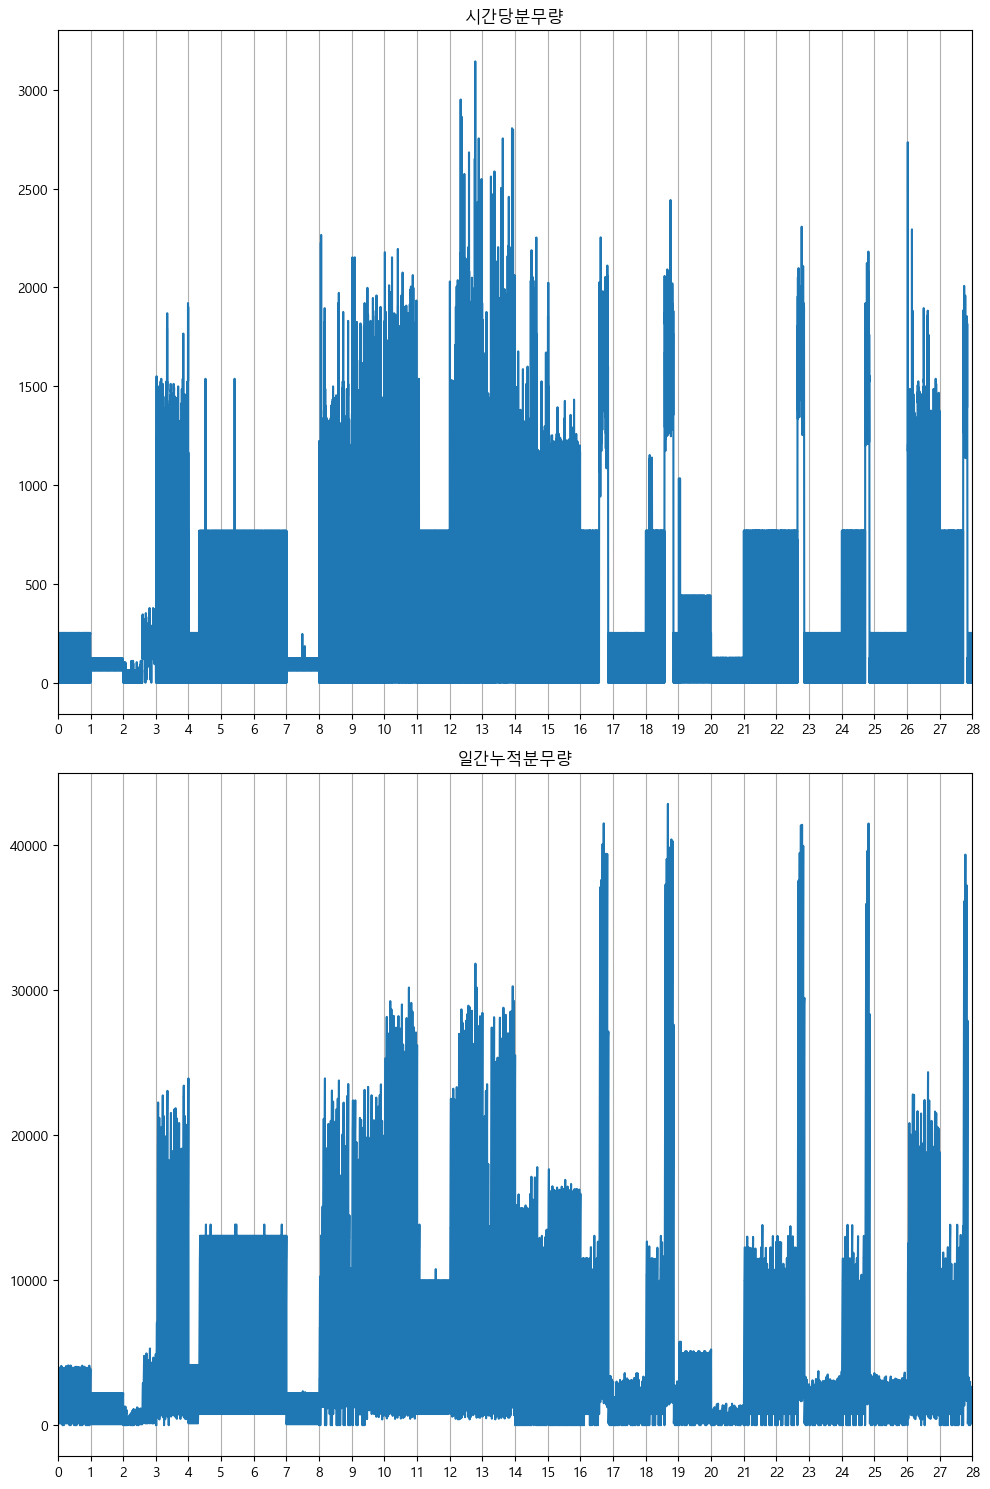

       시간당분무량   일간누적분무량
8662  1120.05  26271.86
8663  1261.51  27533.37
8664   537.52    537.52
8665   537.52   1075.04
8666  1415.83   2490.87
8667     0.00   2490.87
       시간당분무량   일간누적분무량
8710  2433.00  26162.55
8711  1203.64  27366.19
8712   653.26    653.26
8713   653.26   1306.52
8714  1415.83   2722.35
8715     0.00   2722.35


In [20]:
showplot(df_train_input,['시간당분무량','일간누적분무량'],28)

for idx_list in anomaly_water_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당분무량':'일간누적분무량'])

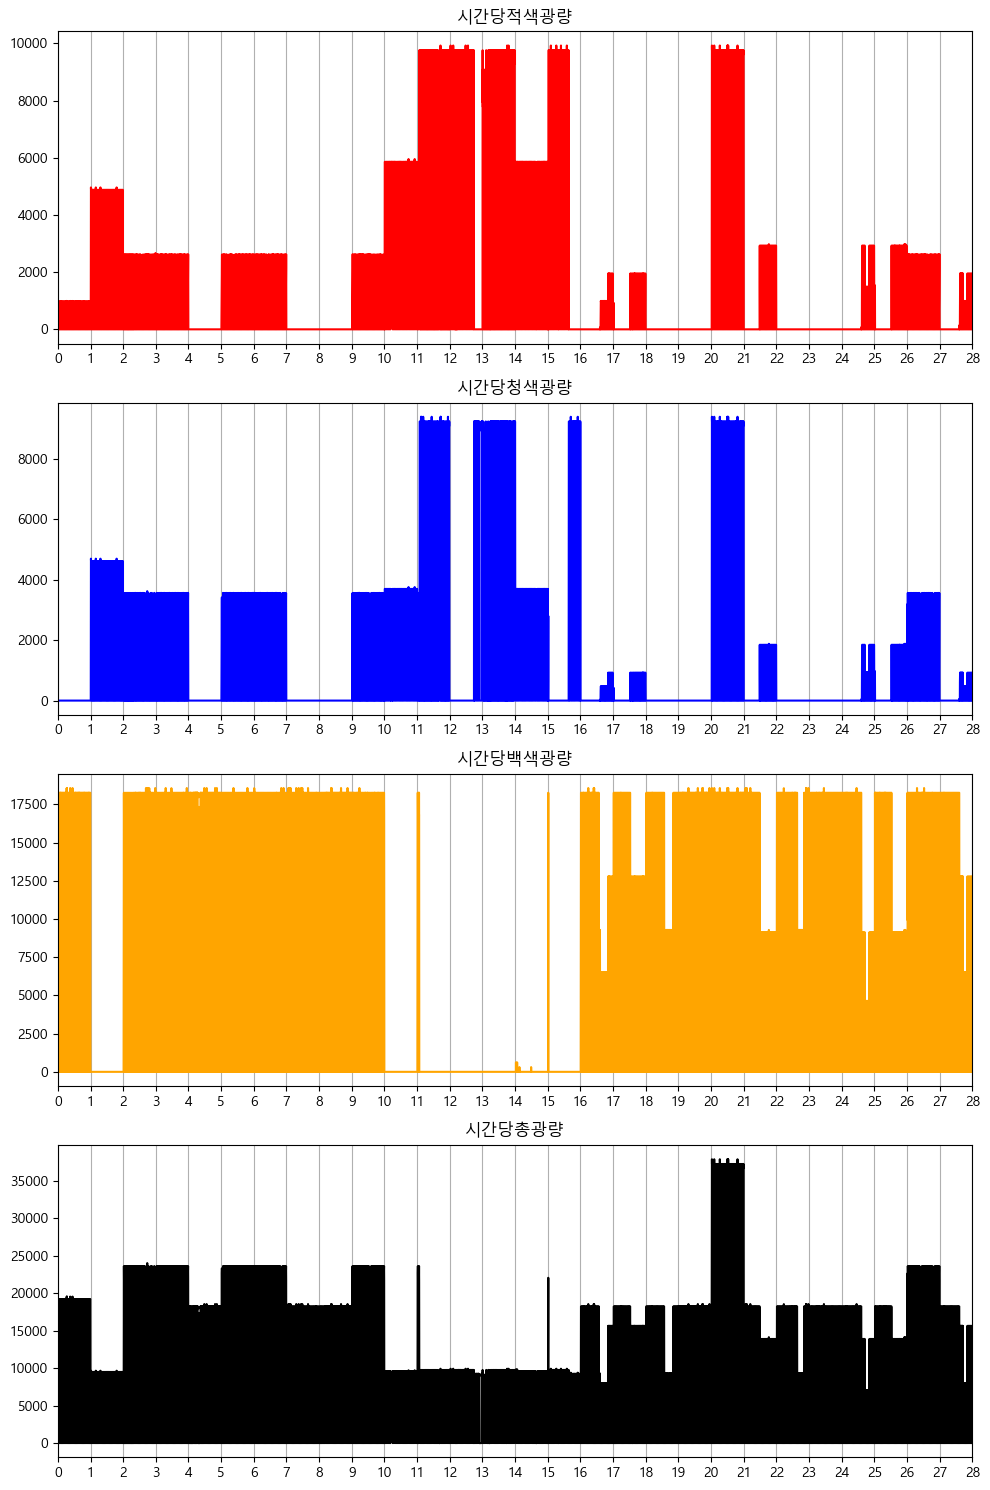

In [21]:
showplot(df_train_input, ['시간당적색광량','시간당청색광량','시간당백색광량','시간당총광량'],xtick_num=28,colors=['red','blue','orange','black'])

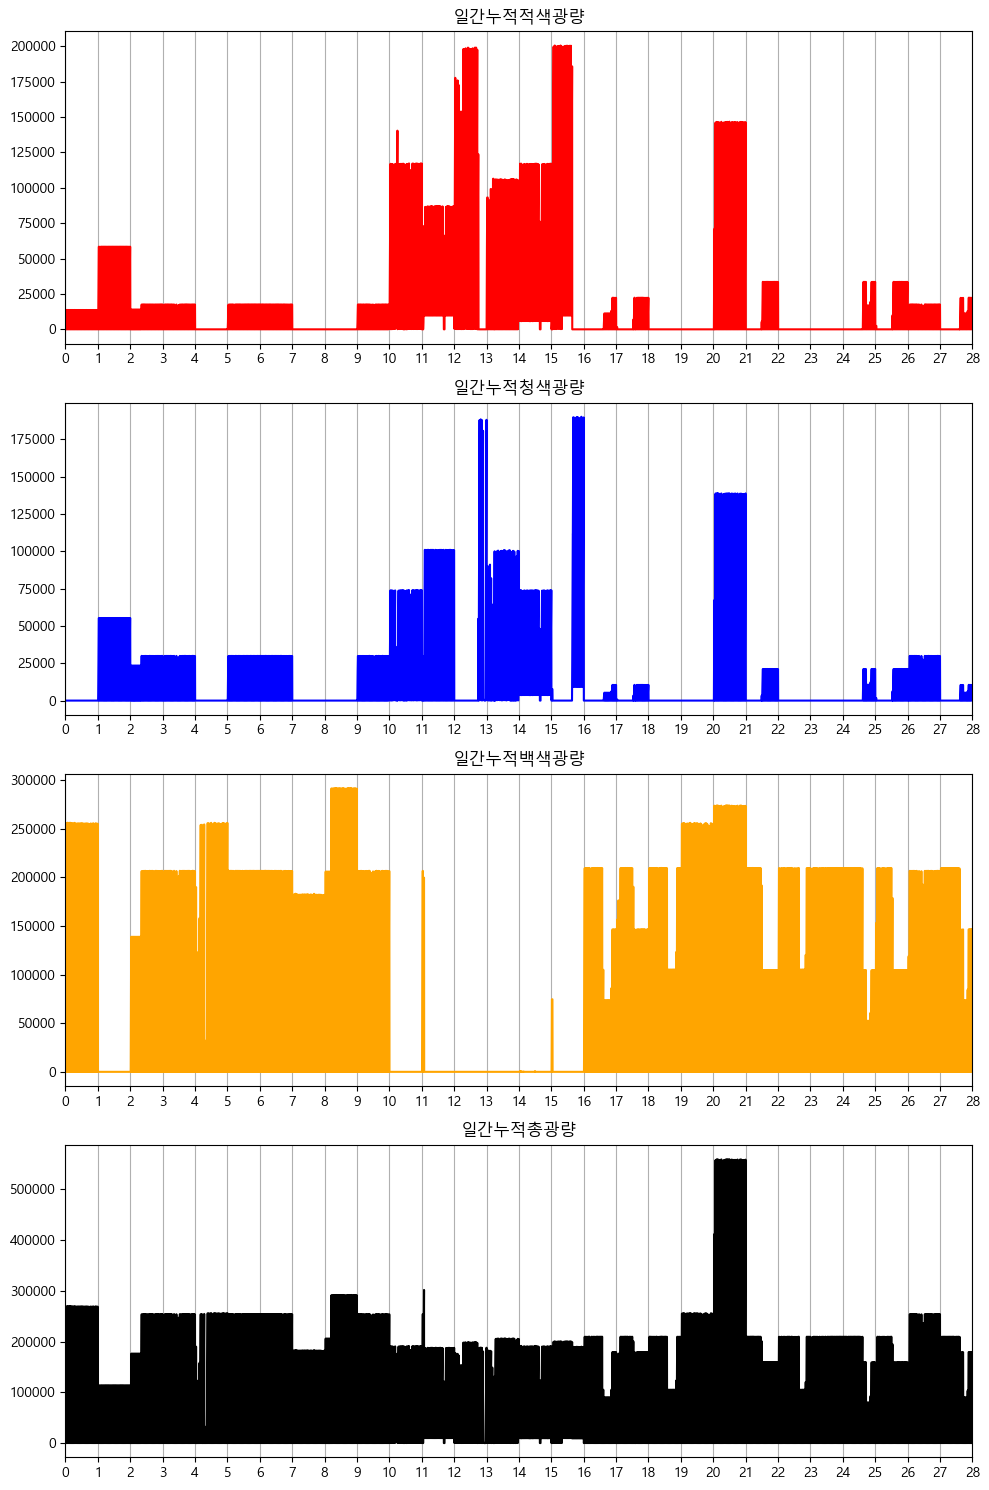

In [22]:
showplot(df_train_input, ['일간누적적색광량','일간누적청색광량','일간누적백색광량','일간누적총광량'],xtick_num=28,colors=['red','blue','orange','black'])

In [23]:
for idx_list in anomaly_redlight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당적색광량':'일간누적적색광량'])
for idx_list in anomaly_bluelight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당청색광량':'일간누적청색광량'])
for idx_list in anomaly_whitelight_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당백색광량':'일간누적백색광량'])
for idx_list in anomaly_light_idx_lists:
    print(df_train_input.loc[range(idx_list[0]-3,idx_list[-1]+3),'시간당총광량':'일간누적총광량'])

        시간당적색광량    일간누적적색광량
3372  1323.8400   6326.3004
3373  1495.9392   7822.2396
3374  1659.7644   9482.0040
3375  1659.7644  11141.7684
3376  2128.0728  13269.8412
3377  2616.2388  15886.0800
        시간당청색광량    일간누적청색광량
3372  3101.6700  13258.8560
3373  3264.5860  16523.4420
3374  3419.6695  19943.1115
3375  3419.6695  23362.7810
3376  3223.8570  26586.6380
3377  2302.7550  28889.3930
         시간당백색광량     일간누적백색광량
3372  18255.1900  108977.2961
3373  18255.1900  127232.4861
3374  18255.1900  145487.6761
3375  18255.1900  163742.8661
3376  17744.6635  181487.5296
3377  16831.9040  198319.4336
          시간당총광량      일간누적총광량
3372  22680.7000  128562.4525
3373  23015.7152  151578.1677
3374  23334.6239  174912.7916
3375  23334.6239  198247.4155
3376  23096.5933  221344.0088
3377  21750.8978  243094.9066


#### 시간당 광량 및 누적광량들의 이상값들을 이전 값에서 가져오는 것으로 해결하였다.  일간 누적 광량들도 조정된 값에 맞추어 연산되었다.

In [24]:
df_train_input.describe()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,13.500000,26.032475,63.947718,499.029870,1.507566,523.754489,6368.827806,6323.887039,72985.157131,1572.418470,18206.359016,1243.074695,14149.703387,9139.380204,105341.219534
std,8.077962,3.943901,11.645382,120.468588,1.042010,544.201487,6906.660634,8120.302985,86081.478567,2936.280442,34385.315268,2470.257771,27744.564605,9087.018819,97437.426978
min,0.000000,13.238833,15.348148,314.883333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.750000,23.975000,57.497500,420.312500,0.929581,0.000000,1234.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7280.962850
50%,13.500000,26.291714,62.121801,474.050424,1.308517,252.000000,3362.750000,0.000000,23205.750000,0.000000,0.000000,0.000000,0.000000,9242.350000,92337.840000
75%,20.250000,28.110000,73.158333,551.216667,2.291322,769.000000,9993.267500,18236.625400,145422.700000,1495.939200,17529.296400,1306.461000,18610.020000,18255.190000,177610.067800
max,27.000000,40.000000,93.350002,1714.850000,5.462324,3144.130000,42855.230000,18564.600000,292014.969800,9928.800000,200561.760000,9399.000000,190016.450000,37892.400000,559488.881000


#### 새롭게 만들어진 데이터셋의 모습

## train_target 분석

In [25]:
df_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT')
df_target = pd.DataFrame(df_target.to_numpy().reshape(28,-1),columns=[f'DAT {i}' for i in range(1,29)])
df_target.describe()

,DAT 1,DAT 2,DAT 3,DAT 4,DAT 5,DAT 6,DAT 7,DAT 8,DAT 9,DAT 10,DAT 11,DAT 12,DAT 13,DAT 14,DAT 15,DAT 16,DAT 17,DAT 18,DAT 19,DAT 20,DAT 21,DAT 22,DAT 23,DAT 24,DAT 25,DAT 26,DAT 27,DAT 28
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,1.683381,2.288304,2.667284,3.204181,3.950850,5.072838,6.120353,7.068996,8.696625,10.601932,13.187141,15.778952,19.169680,22.801709,26.467274,30.593625,35.116147,39.461774,44.726545,50.653290,56.878973,63.378763,69.545935,76.214809,82.604848,87.624705,93.648605,98.543539
std,2.357028,2.578429,2.863601,3.322651,3.951373,4.825686,6.155678,6.538068,8.650560,10.965087,13.910636,16.321852,19.699166,23.994459,26.805522,30.430168,32.946396,34.602265,36.923526,39.067819,39.865393,41.344469,41.480378,40.949942,39.956977,40.086062,40.590651,40.856286
min,0.167719,0.179933,0.228738,0.397851,0.475272,1.240123,1.418845,1.864262,2.871731,4.080100,4.588153,4.871243,5.543811,5.939825,6.339173,6.926151,7.158578,7.259689,7.694598,9.850825,10.019230,11.066003,11.119526,11.783012,15.177433,18.093890,21.895447,22.931393
25%,0.234007,0.539419,0.666719,1.100875,1.750411,2.413267,2.816484,3.609895,4.250393,4.764928,5.923933,7.452890,9.217663,11.057167,12.564989,14.599446,16.669219,20.803403,24.225788,27.853155,31.772036,37.881498,44.575317,52.119185,60.412929,63.956744,71.497518,75.567478
50%,0.988700,1.517878,1.772020,2.417215,2.865205,3.160013,3.728319,4.431971,4.873874,5.928238,7.425005,9.274358,11.002584,13.121927,15.708030,18.428123,22.202628,27.072246,32.308994,38.183387,46.134875,55.346405,61.643009,67.860276,76.057643,80.321376,89.205182,94.431764
75%,2.063935,2.966928,3.227872,3.429209,3.906346,4.626884,5.555892,6.800245,7.678853,9.236044,11.149873,13.423998,17.650058,20.283629,25.295135,30.039105,36.003334,40.571272,45.167597,50.343688,59.341831,68.845917,76.654943,87.519219,97.486725,107.991003,118.245645,128.674381
max,11.764163,12.523265,13.760913,15.813904,17.596470,19.966275,26.237032,26.383172,36.904134,47.230119,60.446871,70.086986,82.520253,102.048533,112.520310,125.342957,126.995971,132.381327,139.193548,148.734949,150.269005,157.561716,159.213888,159.283347,159.413154,159.735773,162.479377,164.150300


#### 각 상추들의 잎 중량을 DAT마다 보여주는 describe이다. 각 상추 케이스마다 잎 중량이 상이한 것을 알 수 있다. 특히 28일자 기준으로는 MAX는 164g 이나 MIN은 22g 으로 무려 7~8배나 차이가 나는 것을 알 수 있다.

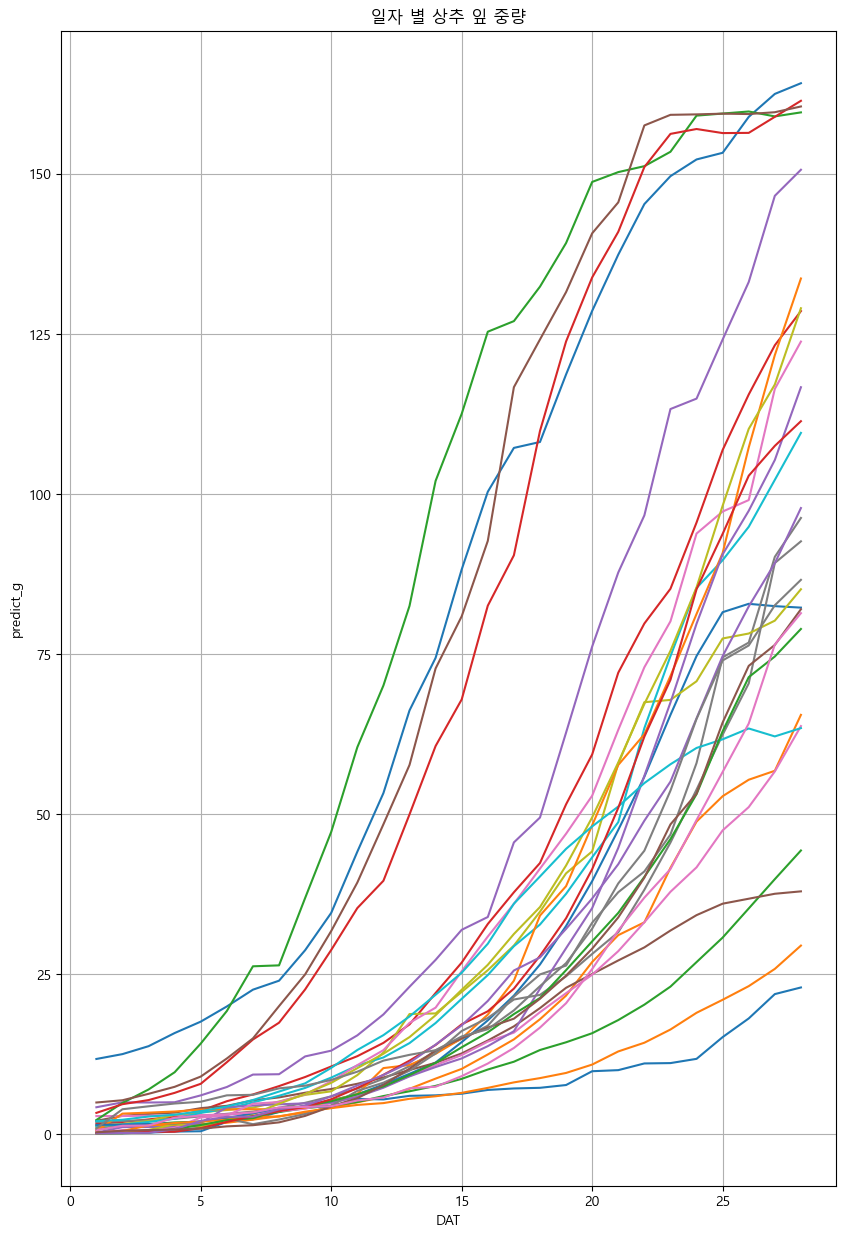

In [26]:
for idx in range(1,29):
    plt.plot(range(1,29),df_target.iloc[idx-1,:].to_numpy())
plt.xlabel('DAT')
plt.ylabel('predict_g')
plt.grid(which='major', axis='both')
plt.title('일자 별 상추 잎 중량')
plt.show()

#### 다음은 모든 28개의 상추 케이스들을 보여주는 그래프이다. 각 상추별로 성장곡선이 크게 다른 것을 확인 할 수 있다. 때문에 실제로 데이터를 넣을 때 각 일자 별로 넣는 것이 아닌 상추 각 케이스별로 input 데이터를 만들어야 한다.

In [27]:
df_train_input.head()

,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,25.355000,81.398334,545.566667,1.406689,126.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,25.391667,81.483333,558.583333,1.411070,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df_train_target.head()

,predicted_weight_g
0,0.167719
1,0.181787
2,0.265921
3,0.423650
4,0.475272


## Data load method 생성

In [29]:
# Dataset 로드 함수
def windowed_dataset(x,y,window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride=1, shift=window_size, drop_remainder=False)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 window dataset 구성
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds = tf.data.Dataset.zip((ds_x,ds_y))
    if shuffle:
        ds = ds.shuffle(SEED)
    return ds.batch(batch_size).prefetch(1)

In [30]:
train_data = windowed_dataset(df_train_input,df_train_target,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)

In [31]:
# 아래의 코드로 데이터셋의 구성 확인 가능
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size,window_size,feature개수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size,window_size,feature개수): {data[1].shape}')

데이터셋(X) 구성(batch_size,window_size,feature개수): (16, 24, 15)
데이터셋(Y) 구성(batch_size,window_size,feature개수): (16, 1)


## Model define

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1,activation="linear")(x)
    return keras.Model(inputs, outputs, name="Transformer")

In [33]:
def dnn_model():
    model = build_model(
        input_shape=[CFG.WINDOW_SIZE,15],
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[1024],
        mlp_dropout=CFG.dropout_rate,
        dropout=CFG.dropout_rate,
    )

    model.compile(
        loss="mae",
        optimizer=keras.optimizers.Adam(learning_rate=CFG.learning_rate),
        metrics=["mape"],
    )
    return model

In [34]:
model = dnn_model()
model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 15)]     0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 24, 15)       64527       input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 15)       0           multi_head_attention[0][0]       
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 24, 15)       30          dropout[0][0]          

## KFold cross-validation

In [35]:
"""
kf = KFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=SEED)

train_input = df_train_input.to_numpy().reshape(-1,CFG.WINDOW_SIZE,15)
train_target = df_train_target.to_numpy()

# Scaler
MMS = MinMaxScaler(feature_range=(0.0,1.0))

for fold, (train_idx, test_idx) in enumerate(kf.split(train_input)):
    print('='*25, '>', f'Fold {fold+1}', '<', '='*25)
    checkpoint_filepath = f'fold{fold+1}.hdf5'
    
    X_train, X_valid = train_input[train_idx], train_input[test_idx]
    y_train, y_valid = train_target[train_idx], train_target[test_idx]
    
    # data scaling
    X_train = X_train.reshape(-1,15)
    X_valid = X_valid.reshape(-1,15)
    X_train = MMS.fit_transform(X_train)
    X_valid = MMS.transform(X_valid)
    train_data = windowed_dataset(X_train,y_train,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)
    valid_data = windowed_dataset(X_valid,y_valid,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)
    
    lr = ReduceLROnPlateau(monitor="val_loss", factor=CFG.factor, patience=CFG.patience_1,
                           verbose=CFG.VERBOSE)
    es = EarlyStopping(monitor="val_loss", patience=CFG.patience_2, mode="min",
                           restore_best_weights=True, verbose=CFG.VERBOSE)
    sv = ModelCheckpoint(checkpoint_filepath, monitor = 'val_loss', verbose = CFG.VERBOSE,
                         save_best_only = True, save_weights_only = True, mode = 'min')
        
    model = dnn_model()
    history = model.fit(train_data,
                        validation_data=valid_data,
                        epochs=CFG.EPOCHS, batch_size=CFG.BATCH_SIZE, callbacks=[lr,es,sv])        
    history_list += [history]
        
    del X_train, X_valid, y_train, y_valid, model
    gc.collect()
"""

'\nkf = KFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=SEED)\n\ntrain_input = df_train_input.to_numpy().reshape(-1,CFG.WINDOW_SIZE,15)\ntrain_target = df_train_target.to_numpy()\n\n# Scaler\nMMS = MinMaxScaler(feature_range=(0.0,1.0))\n\nfor fold, (train_idx, test_idx) in enumerate(kf.split(train_input)):\n    print(\'=\'*25, \'>\', f\'Fold {fold+1}\', \'<\', \'=\'*25)\n    checkpoint_filepath = f\'fold{fold+1}.hdf5\'\n    \n    X_train, X_valid = train_input[train_idx], train_input[test_idx]\n    y_train, y_valid = train_target[train_idx], train_target[test_idx]\n    \n    # data scaling\n    X_train = X_train.reshape(-1,15)\n    X_valid = X_valid.reshape(-1,15)\n    X_train = MMS.fit_transform(X_train)\n    X_valid = MMS.transform(X_valid)\n    train_data = windowed_dataset(X_train,y_train,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)\n    valid_data = windowed_dataset(X_valid,y_valid,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)\n    \n    lr = ReduceLROnPlateau(monitor="val_loss", factor=C

### Train

In [36]:
def train(input_paths,target_paths,scalar):
    
    df_train_input = pd.concat(map(pd.read_csv, all_input_list)).drop(columns='obs_time').reset_index(drop=True)
    df_train_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT').reset_index(drop=True)

    df_train_input = feature_processing(df_train_input)
    train_input = df_train_input.to_numpy()
    train_target = df_train_target.to_numpy()
    
    train_input = scalar.fit_transform(train_input)
    train_data = windowed_dataset(train_input,train_target,CFG.WINDOW_SIZE,CFG.BATCH_SIZE, True)
    
    lr = ReduceLROnPlateau(monitor="loss", factor=CFG.factor, patience=CFG.patience_1,
                       verbose=CFG.VERBOSE)
    es = EarlyStopping(monitor="loss", patience=CFG.patience_2, mode="min",
                           restore_best_weights=True, verbose=CFG.VERBOSE)
    sv = ModelCheckpoint('Transformer.hdf5', monitor ='loss', verbose = CFG.VERBOSE,
                         save_best_only = True, save_weights_only = True, mode = 'min')
    
    model = dnn_model()
    history = model.fit(train_data,epochs=CFG.EPOCHS, batch_size=CFG.BATCH_SIZE, callbacks=[lr,es,sv])
    return model,history,scalar

In [37]:
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))

# Scaler
MMS = MinMaxScaler(feature_range=(0.0,1.0))

model,history,MMS = train(all_input_list,all_target_list,MMS)

Epoch 1/400
49/49 [==============================] - 8s 33ms/step - loss: 31.0255 - mape: 286.3532

Epoch 00001: loss improved from inf to 31.02548, saving model to Transformer.hdf5
Epoch 2/400
49/49 [==============================] - 1s 28ms/step - loss: 24.5959 - mape: 257.5601

Epoch 00002: loss improved from 31.02548 to 24.59589, saving model to Transformer.hdf5
Epoch 3/400
49/49 [==============================] - 1s 22ms/step - loss: 19.5148 - mape: 124.9428

Epoch 00003: loss improved from 24.59589 to 19.51475, saving model to Transformer.hdf5
Epoch 4/400
49/49 [==============================] - 1s 27ms/step - loss: 20.7502 - mape: 148.2784

Epoch 00004: loss did not improve from 19.51475
Epoch 5/400
49/49 [==============================] - 1s 29ms/step - loss: 18.4721 - mape: 118.2010

Epoch 00005: loss improved from 19.51475 to 18.47215, saving model to Transformer.hdf5
Epoch 6/400
49/49 [==============================] - 1s 24ms/step - loss: 17.6635 - mape: 159.1903

Epoch 000

49/49 [==============================] - 1s 22ms/step - loss: 7.3128 - mape: 71.7520

Epoch 00050: loss improved from 7.73073 to 7.31276, saving model to Transformer.hdf5
Epoch 51/400
49/49 [==============================] - 1s 27ms/step - loss: 7.2013 - mape: 65.5603

Epoch 00051: loss improved from 7.31276 to 7.20134, saving model to Transformer.hdf5
Epoch 52/400
49/49 [==============================] - 1s 28ms/step - loss: 7.0449 - mape: 68.7999

Epoch 00052: loss improved from 7.20134 to 7.04486, saving model to Transformer.hdf5
Epoch 53/400
49/49 [==============================] - 1s 22ms/step - loss: 7.3283 - mape: 67.0235

Epoch 00053: loss did not improve from 7.04486
Epoch 54/400
49/49 [==============================] - 1s 26ms/step - loss: 6.8446 - mape: 64.6664

Epoch 00054: loss improved from 7.04486 to 6.84462, saving model to Transformer.hdf5
Epoch 55/400
49/49 [==============================] - 1s 29ms/step - loss: 7.3209 - mape: 61.4979

Epoch 00055: loss did not improv

49/49 [==============================] - 1s 22ms/step - loss: 5.7825 - mape: 47.5494

Epoch 00100: loss did not improve from 5.68262
Epoch 101/400
49/49 [==============================] - 1s 27ms/step - loss: 5.6764 - mape: 49.2605

Epoch 00101: loss improved from 5.68262 to 5.67644, saving model to Transformer.hdf5
Epoch 102/400
49/49 [==============================] - 1s 28ms/step - loss: 5.8658 - mape: 49.5488

Epoch 00102: loss did not improve from 5.67644
Epoch 103/400
49/49 [==============================] - 1s 25ms/step - loss: 5.7240 - mape: 47.8266

Epoch 00103: loss did not improve from 5.67644
Epoch 104/400
49/49 [==============================] - 1s 22ms/step - loss: 5.6629 - mape: 49.6552

Epoch 00104: loss improved from 5.67644 to 5.66289, saving model to Transformer.hdf5
Epoch 105/400
49/49 [==============================] - 1s 29ms/step - loss: 5.7427 - mape: 52.9804

Epoch 00105: loss did not improve from 5.66289
Epoch 106/400
49/49 [==============================] - 1

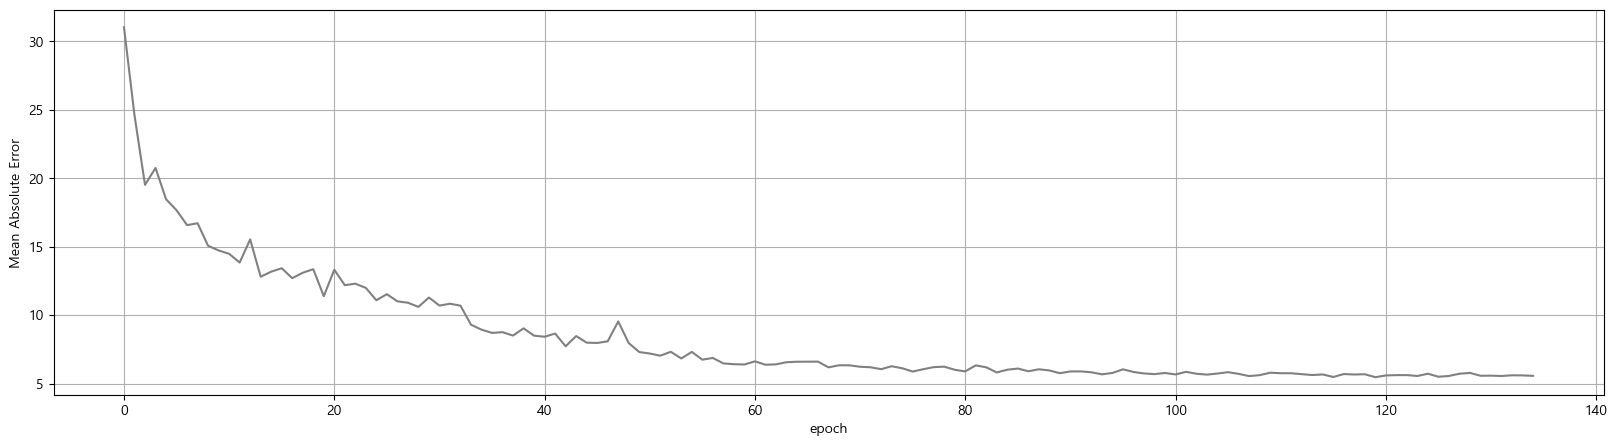

In [38]:
def plot_hist(hist, with_grid=True):
    plt.figure(figsize=(20,5))
    plt.plot(hist.history["loss"], color='grey')
    plt.title("")
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("epoch")
    if with_grid:
        plt.grid(which='major', axis='both')
    plt.show()
plot_hist(history)

## Save history

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_transformer.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## 결과 확인

In [40]:
def predict(input_paths,scalar):
    df_test_input = pd.concat(map(pd.read_csv, input_paths)).drop(columns='obs_time').reset_index(drop=True)
    df_test_input = feature_processing(df_test_input)
    test_input = df_test_input.to_numpy()
    test_input = scalar.transform(test_input)
    test_input = test_input.reshape(-1,CFG.WINDOW_SIZE,15)
    
    x = tf.data.Dataset.from_tensor_slices(test_input).batch(CFG.BATCH_SIZE)
    x = x.prefetch(1)
    
    return model.predict(x)
    
y_pred = predict(all_input_list,MMS)

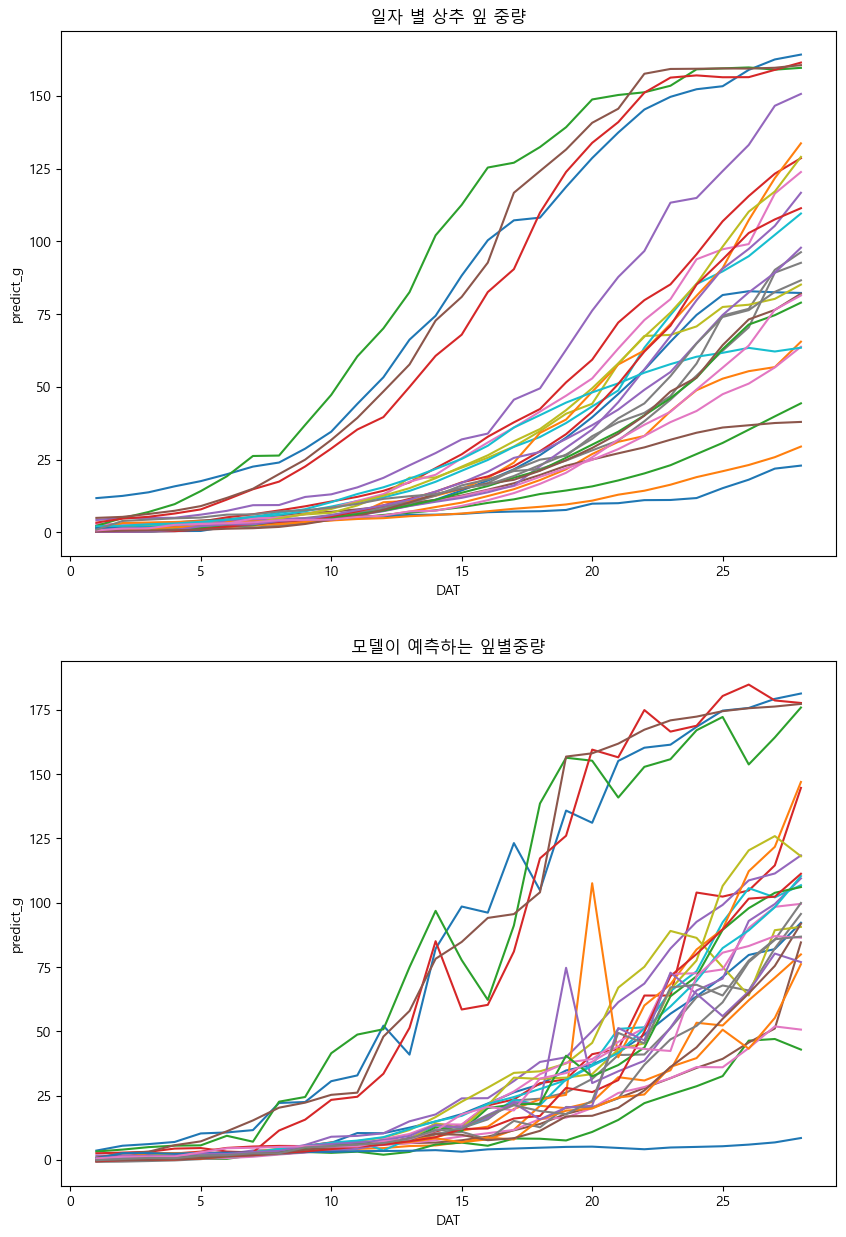

In [41]:
df_target = pd.concat(map(pd.read_csv, all_target_list)).drop(columns='DAT')
df_target = pd.DataFrame(df_target.to_numpy().reshape(28,-1),columns=[f'DAT {i}' for i in range(1,29)])

fig, ax = plt.subplots(2,1)

y_pred = y_pred.reshape(28,28)

for idx in range(1,29):
    ax[0].plot(range(1,29),df_target.iloc[idx-1,:].to_numpy())
    ax[0].set_xlabel('DAT')
    ax[0].set_ylabel('predict_g')
    ax[0].set_title('일자 별 상추 잎 중량')

for idx in range(1,29):
    ax[1].plot(range(1,29),y_pred[idx-1])
    ax[1].set_xlabel('DAT')
    ax[1].set_ylabel('predict_g')
    ax[1].set_title('모델이 예측하는 잎별중량')

plt.show()

## Submission

In [48]:
test_input_list  = sorted(glob.glob('./data/test_input/*.csv'))
test_target_list = sorted(glob.glob('./data/test_target/*.csv'))

y_pred = predict(test_input_list ,MMS)

ValueError: No objects to concatenate

In [43]:
y_pred = y_pred.reshape(-1,28)

In [44]:
for idx, (test_input_path, test_target_path) in enumerate(zip(test_input_list, test_target_list)):
    print(test_target_path)

    submit_df = pd.read_csv(test_target_path)
    submit_df['predicted_weight_g'] = y_pred[idx]
    submit_df.to_csv(test_target_path, index=False)

./data/test_target\TEST_01.csv
./data/test_target\TEST_02.csv
./data/test_target\TEST_03.csv
./data/test_target\TEST_04.csv
./data/test_target\TEST_05.csv


In [47]:
import zipfile
os.chdir("data/test_target/")
submission = zipfile.ZipFile("submission.zip", 'w')
for path in test_target_list:
    path = path.split('\\')[-1]
    submission.write(path)
submission.close()

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/test_target/'